# Michaelis-Menten kinetics dynamics

### The Michaelis-Menten kinetics is given by the following system of (coupled) ordinary differential equations (ODEs):

$$
\dot{x}^{(\nu)}_i = -x^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}
$$

# TODOs
- create many cohorts with uniform p such that every cohort has a different p but an identical "base model" weight matrix (p $\in$ [0.05, 0.1, 0.15, ..., 1]) ✅
- run "negative spearman correlation" (it's a measure, just like Euclidean distance) on the results
- Dimensionality reduction (PCA) - look for libraries that can perform dimensionality reduction. assert a "cloud like" distribution
- "Colonial expansion" - Make the defects uneven (e.g. base_model W $->$ 10 Ws with p = 0.2 and 40 Ws with p = 0.8)
- "Colonial expansion" should increase GCL (higher p $->$ higher GCL)

In [280]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  # Import the odeint function from scipy for solving ODEs
from scipy.integrate import solve_ivp  # Import the solve_ivp function from scipy for solving ODEs
import random

In [281]:
# Set up the system of ODEs
def ode_system(x, t, W):  # t must be passed even if not used
    N = len(x)  # Get the number of elements in the state vector
    derivative_vector = np.zeros(N)  # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N) if j != i)  # list comprehension
        derivative_vector[i] = -x[i] + sum_term
    return derivative_vector

In [282]:
# Initialize parameters
N = 100  # Number of genes in a cell
avg_deg = 3
M = 50  # Number of "defects" of the matrix W

initial_conditions = [np.random.rand(N) for _ in range(N)]

dist = lambda x: random.random() < x
q = 1  # Affects the range of the random numbers generated
probability_spacing = 0.05
num_of_cohorts = int(1 / probability_spacing) + 1
p = np.linspace(0, 1, num_of_cohorts)
W = [[np.zeros((N, N)) for _ in range(M)] for __ in range(
    num_of_cohorts)]  # Initialize the weight matrix with zeros; W[cohort index][defect number][(row, column)] TODO: Perhaps there is a simpler more elegant way to do this with smaller dimension arrays.

num_of_time_stamps = 1000
t_final = 10
t = np.linspace(0, t_final, num_of_time_stamps)

# TODO: Figure out how to make the odeint function stop when the system reaches a steady state or after a certain time period

In [283]:
print(p)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


In [284]:
print(len(W))  # len(p) = num_of_cohorts = 21 W is an array that each element represents a cohort with different p
print(len(W[0]))  # M = 50 an element in W is an array of 50 weight matrices
print(len(W[0][0][0]))  # N = 100 num of genes each weight matrix is an NxN matrix
print(len(W[0][0][1]))  # N = 100 num of genes each weight matrix is an NxN matrix

21
50
100
100


In [285]:
for cohort_index in range(num_of_cohorts):
    # for each cohort, create a system of 50 w defect matrices

    # Set the base weight matrix for the current cohort
    # TODO: this is weird since I defined avg_deg as the average degree but I use it as a probability distribution (actual average might be different) maybe change that in the future
    base_model = np.array([[np.random.uniform(0, 2 * q) if (row != column and dist(avg_deg / (N - 1))) else 0
                            for column in range(N)] for row in range(N)])

    # TODO: the first iteration is useless since p[0] = 0 by definition and its a simple copy of base_model. Maybe change that in the future
    # Create defects of the weight matrix
    # TODO: Too many indentations, maybe refactor this code
    for defect_index in range(M):
        for row in range(N):
            for column in range(N):
                if base_model[row, column] != 0:
                    if dist(p[cohort_index]):
                        # TODO: What if, by chance np.random.uniform(0, 2 * q) is the same as base_model[row, column] or if it is 0? these are edge cases that are rare and therefore not handled
                        W[cohort_index][defect_index][row, column] = np.random.uniform(0, 2 * q)
                    else:
                        W[cohort_index][defect_index][row, column] = base_model[row, column]
                else:
                    W[cohort_index][defect_index][row, column] = 0

In [286]:
# This block takes too long to run :(
# Initialize the results array
results = [[np.zeros((num_of_time_stamps, N)) for _ in range(M)] for __ in range(num_of_cohorts)]

# Solve the ODEs for all M weight matrix and corresponding initial conditions
for cohort_index in range(num_of_cohorts):
    for defect_index in range(M):
        results[cohort_index][defect_index] = odeint(ode_system, initial_conditions[defect_index], t,
                                                     args=(W[cohort_index][defect_index],))

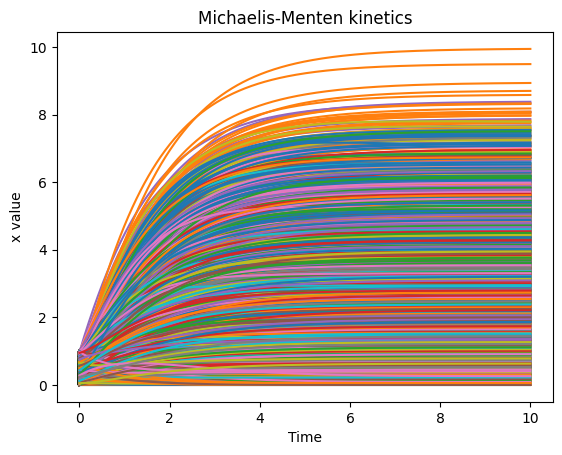

In [287]:
# Plot the results
for cohort_index in range(num_of_cohorts):
    for defect_index in range(M):
        for gene in range(N):
            plt.plot(t, results[cohort_index][defect_index][:, gene])
plt.xlabel('Time')
plt.ylabel('x value')
plt.title('Michaelis-Menten kinetics')
plt.show()

# ---------

In [91]:
# initial state
results[0][0, :]

array([0.99108996, 0.50154044, 0.25027061, 0.44460481, 0.83630151,
       0.76515121, 0.10470698, 0.53775734, 0.4629126 , 0.02449989,
       0.36404683, 0.64064896, 0.34919547, 0.33707565, 0.93263401,
       0.6964908 , 0.57236488, 0.29284949, 0.64870106, 0.77118013,
       0.78996057, 0.31014044, 0.34785423, 0.33274428, 0.79133258,
       0.8632042 , 0.2601542 , 0.60872645, 0.87827988, 0.43722596,
       0.47726488, 0.64229824, 0.0270669 , 0.73977926, 0.73651241,
       0.44671052, 0.11482295, 0.47194655, 0.7741788 , 0.24219892,
       0.46785625, 0.11135329, 0.05482015, 0.99453968, 0.7637334 ,
       0.94220777, 0.48963   , 0.64406807, 0.44781514, 0.44194173,
       0.43361473, 0.67868609, 0.38591315, 0.8048496 , 0.0242426 ,
       0.39596862, 0.1199428 , 0.45027459, 0.20118141, 0.26280618,
       0.92170933, 0.21640192, 0.94333455, 0.76059428, 0.86347381,
       0.59043451, 0.48170835, 0.03304476, 0.87383428, 0.12342926,
       0.75475447, 0.45851461, 0.6617266 , 0.51318838, 0.62925

In [92]:
final_state = [np.random.rand(N) for _ in range(N)]
# final state
for m in range(M):
    final_state[m] = results[m][-1, :]

In [93]:
# Calculate the variance of the final state
final_state_variance = np.var(final_state)
print(final_state_variance)

1.4185021388968566


In [94]:
# W2_variance = np.var(W_strong_influence)
# print(W_strong_influence)

In [95]:
# Save the final state vector to a csv file
# np.savetxt('final_state.csv', final_state, delimiter=',')